In [1]:
using DataFrames, CSV, Glob
using Plots
using LinearAlgebra
using FFTW

In [2]:
data_files = glob("*.csv", ".")
num_files = length(data_files)

data_frames = []
throttles = zeros(num_files)
voltages = zeros(num_files)
ss_vals = zeros(num_files)

for (i, data_file) in enumerate(data_files)
    data_frame = DataFrame(CSV.File(data_file))
    push!(data_frames, data_frame)

    throttles[i] = parse(Float64, data_file[3:5])
    voltages[i] = parse(Float64, data_file[7:11])
    ss_vals[i] = data_frame[350, "Thrust (N)"]
end

effective_voltage = (throttles ./ 999) .* voltages


8-element Vector{Float64}:
  4.744744744744745
  6.366366366366367
  7.907907907907909
 10.0
 11.561561561561561
 13.093093093093096
 14.594594594594595
 16.05

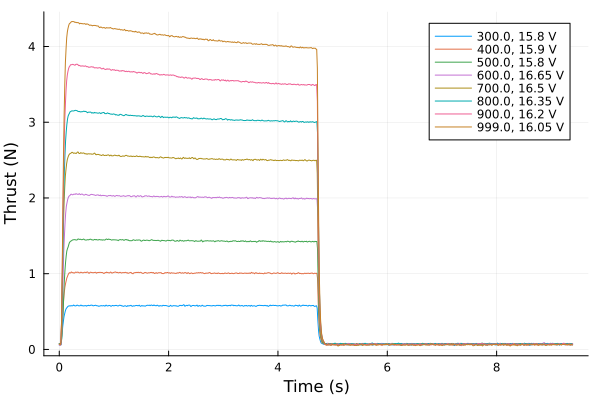

In [3]:
fig = plot(xlabel="Time (s)", ylabel="Thrust (N)")

for (data_frame, throttle, voltage) in zip(data_frames, throttles, voltages)
    plot!(fig, data_frame[!, "Time (s)"], data_frame[!, "Thrust (N)"], label="$throttle, $voltage V")
end

display(fig)

Θ = X \ Y = [0.004971003386589644, -0.9783882008599457]
-(Θ[2]) / Θ[1] = 196.81905739580853


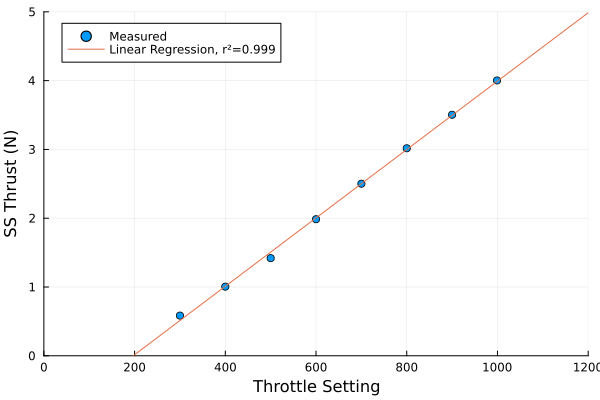

In [4]:
X = hcat(throttles, ones(num_files))
Y = ss_vals
@show Θ = X \ Y

Y_pred = X * Θ
ȳ = sum(ss_vals) / num_files
SS_res = mapreduce((y, f) -> (y - f)^2, +, Y, Y_pred)
SS_tot = mapreduce((y) -> (y - ȳ)^2, +, Y)
r² = 1 - SS_res / SS_tot

@show -Θ[2]/Θ[1]

scatter(throttles, ss_vals,
    xlabel = "Throttle Setting", ylabel = "SS Thrust (N)", label = "Measured",
    xlim = (0, 1200), ylim = (0, 5))
plot!(x -> Θ[1] * x + Θ[2], label = "Linear Regression, r²=$(round(r², digits=3))")

Θ = X \ Y = [0.3031174095857658, -0.9426492572793933]


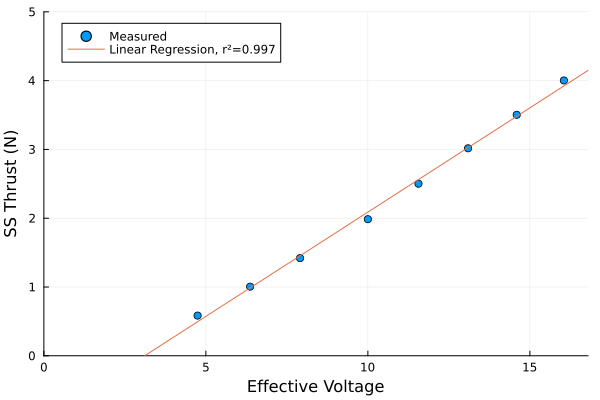

In [5]:
X = hcat(effective_voltage, ones(num_files))
Y = ss_vals
@show Θ = X \ Y

Y_pred = X * Θ
ȳ = sum(ss_vals) / num_files
SS_res = mapreduce((y, f) -> (y - f)^2, +, Y, Y_pred)
SS_tot = mapreduce((y) -> (y - ȳ)^2, +, Y)
r² = 1 - SS_res / SS_tot

scatter(effective_voltage, ss_vals,
    xlabel = "Effective Voltage", ylabel = "SS Thrust (N)", label = "Measured",
    xlim = (0, 16.8), ylim = (0, 5))
plot!(x -> Θ[1] * x + Θ[2], label = "Linear Regression, r²=$(round(r², digits=3))")

In [6]:
init_val = data_frames[3][1, "Thrust (N)"]
@show thrust_tau = (ss_vals[3] - init_val) * (1 - exp(-1))  + init_val
t_start = data_frames[3][4, "Time (s)"]
f_tau = (thrust_tau - data_frames[3][9, "Thrust (N)"]) / (data_frames[3][10, "Thrust (N)"] - data_frames[3][9, "Thrust (N)"])
t_tau = f_tau * (data_frames[3][10, "Time (s)"] - data_frames[3][9, "Time (s)"]) + data_frames[3][9, "Time (s)"]
@show τ = t_tau - t_start
data_frames[3]

τ = 45e-3

thrust_tau = (ss_vals[3] - init_val) * (1 - exp(-1)) + init_val = 0.9244331905904428
τ = t_tau - t_start = 0.061392115965842625


0.045

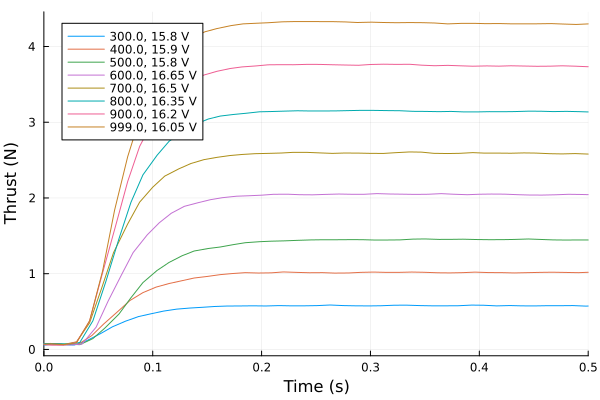

In [7]:
fig = plot(xlabel="Time (s)", ylabel="Thrust (N)", xlim=(0, .5))

for (data_frame, throttle, voltage, ss_val) in zip(data_frames, throttles, voltages, ss_vals)
    plot!(fig, data_frame[!, "Time (s)"], data_frame[!, "Thrust (N)"], label="$throttle, $voltage V")
end

display(fig)

In [8]:
Us = [clamp.(data_frame[:, "Throttle (u)"] .- 197, 0, 1000) for data_frame in data_frames[1:6]]

Y = vcat([data_frame[3:702, "Thrust (N)"] for data_frame in data_frames[1:6]]...)
X = hcat(
    vcat([data_frame[2:701, "Thrust (N)"] for data_frame in data_frames[1:6]]...),
    vcat([data_frame[1:700, "Thrust (N)"] for data_frame in data_frames[1:6]]...),
    vcat([(0*u[3:702] .+ 1*u[2:701] .+ 0.5*u[1:700]) for u in Us]...),
)

Δt = sum(data_frames[3][2:end, "Time (s)"] .- data_frames[3][1:(end-1), "Time (s)"]) / (size(data_frames[3], 1) - 1)
@show Δt

Θ = X \ Y
@show α1, α0, β = Θ

@show p1d = (α1 + √(Complex(α1^2 + 4α0)))/2
@show p2d = -α0 / p1d

@show p1 = log(p1d) / Δt
@show p2 = log(p2d) / Δt

@show ζ = sqrt((real(p2)/imag(p2))^2 / ((real(p2)/imag(p2))^2 + 1))
@show ωₙ = real(p2) / -ζ

@show τ_eff = 1 / (ζ * ωₙ)
@show K = 1.5*β / real(1 - p1d - p2d + p1d*p2d)


Δt = 0.011750938673341677
(α1, α0, β) = Θ = [1.3570571415785417, -0.4927219416568963, 0.0004533823954997725]
p1d = (α1 + √(Complex(α1 ^ 2 + 4α0))) / 2 = 0.6785285707892709 + 0.1797801999096834im
p2d = -α0 / p1d = 0.6785285707892709 - 0.1797801999096834im
p1 = log(p1d) / Δt = -30.117180277972952 + 22.04118345182851im
p2 = log(p2d) / Δt = -30.117180277972952 - 22.04118345182851im
ζ = sqrt((real(p2) / imag(p2)) ^ 2 / ((real(p2) / imag(p2)) ^ 2 + 1)) = 0.8069764072551121
ωₙ = real(p2) / -ζ = 37.32101707956365
τ_eff = 1 / (ζ * ωₙ) = 0.03320363960936204
K = (1.5β) / real(((1 - p1d) - p2d) + p1d * p2d) = 0.005012896439289155


0.005012896439289155

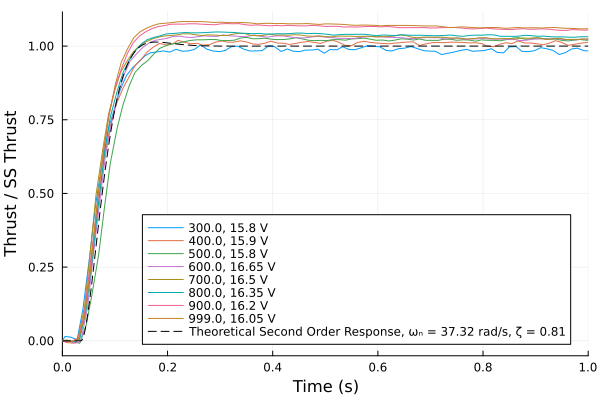

In [9]:
fig = plot(xlabel = "Time (s)", ylabel = "Thrust / SS Thrust", xlim = (0, 1))

for (data_frame, throttle, voltage, ss_val) in zip(data_frames, throttles, voltages, ss_vals)
    plot!(fig, data_frame[!, "Time (s)"], (data_frame[!, "Thrust (N)"] .- data_frame[1, "Thrust (N)"]) ./ (ss_val - data_frame[1, "Thrust (N)"]), label = "$throttle, $voltage V")
end
# plot!(fig, t -> (t > Δt * 3 ? (1 - exp(-(t - Δt * 3)/τ) - (t - Δt * 3)* exp(-(t - Δt * 3)/τ) / τ) : 0), label="Theoretical First Order Response, τ = $(round(τ*1e3, digits=1)) ms", linestyle=:dash, color=:black)
plot!(fig, t -> (t > Δt * 3 ? real(1 - (p1 / (p1 - p2)) * exp((t - Δt * 3)*p2) + (p2 / (p1 - p2)) * exp((t - Δt * 3)*p1)) : 0), label = "Theoretical Second Order Response, ωₙ = $(round(ωₙ, digits=2)) rad/s, ζ = $(round(ζ, digits=2))", linestyle = :dash, color = :black)

display(fig)


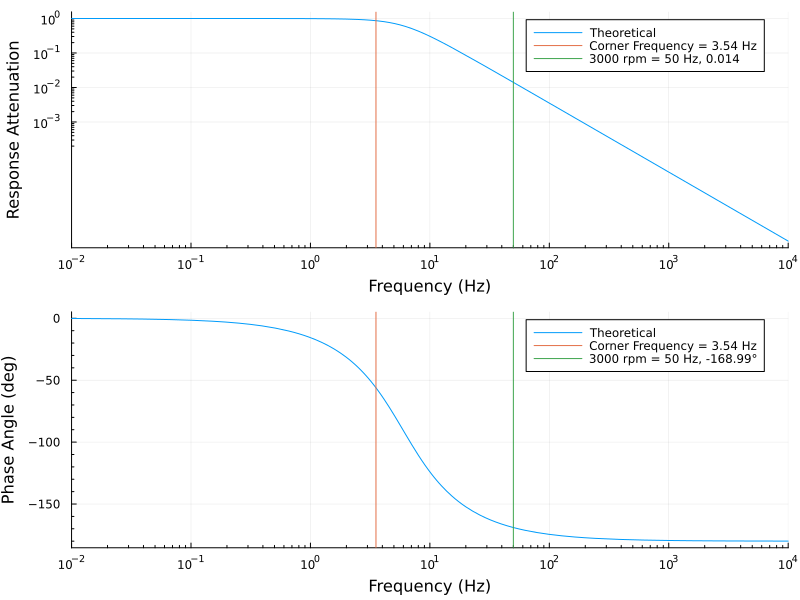

In [10]:
G(ω) = ωₙ^2 / ((ω*im)^2 + 2ζ * ωₙ * (ω*im) + ωₙ^2)

p1 = plot(f -> abs(G(2π * f)), xlim = (10e-3, 10e3), xscale = :log10, yscale = :log10, label = "Theoretical",
    xlabel = "Frequency (Hz)", ylabel = "Response Attenuation", minorticks = true, yticks = 10.0 .^ (-3:0))
vline!(p1, [1 / (2π * τ)], label = "Corner Frequency = $(round(1 / (2π * τ), digits=2)) Hz")
vline!(p1, [50.0], label = "3000 rpm = 50 Hz, $(round(abs(G(2π * 50)), digits=3))")

p2 = plot(f -> angle(G(2π * f)) * 180.0 / π, xlim = (10e-3, 10e3), xscale = :log10, label = "Theoretical",
    xlabel = "Frequency (Hz)", ylabel = "Phase Angle (deg)", minorticks = true)#, yticks=10.0 .^ (-3:0))
vline!(p2, [1 / (2π * τ)], label = "Corner Frequency = $(round(1 / (2π * τ), digits=2)) Hz")
vline!(p2, [50.0], label = "3000 rpm = 50 Hz, $(round(angle(G(2π * 50)) * 180.0 / π, digits=2))°")

plot(p1, p2, layout = (2, 1), size = (800, 600))


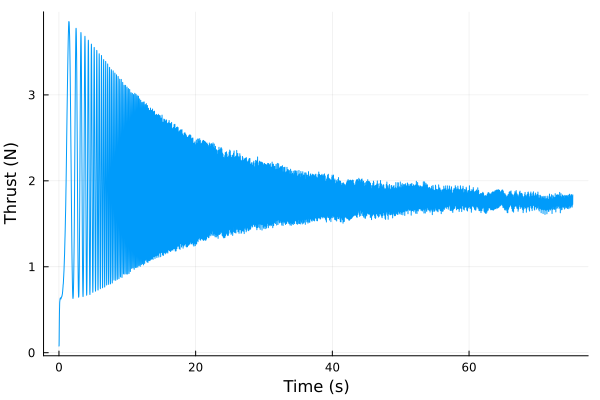

In [11]:
chirp_data = DataFrame(CSV.File("chirp.tsv"))
plot(chirp_data[!, "Time (s)"], chirp_data[!, "Thrust (N)"], label=nothing,
    xlabel="Time (s)", ylabel="Thrust (N)")

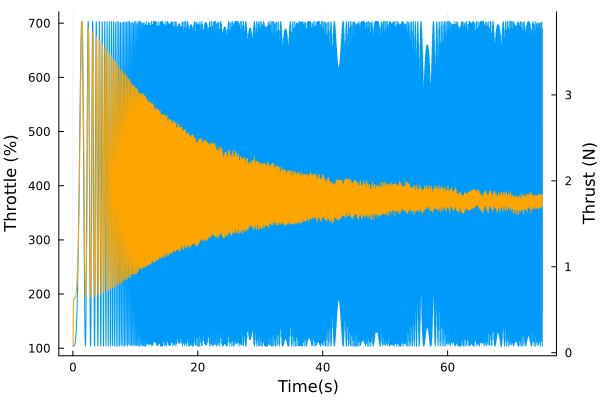

In [22]:
t = chirp_data[:, "Time (s)"]
dt = sum(t[2:end] .- t[1:(end-1)]) ./ (length(t) - 1)

u = clamp.(chirp_data[:, "Throttle (u)"] .- 196, 0, 1000)
y = chirp_data[:, "Thrust (N)"]
plot(t, u, ylabel="Throttle (%)", xlabel="Time(s)", label=nothing)
plot!(twinx(), t, y, ylabel="Thrust (N)", color=:orange, label=nothing)

In [23]:
# us = clamp.(chirp_data[:, "Throttle (u)"] .- 200, 0, 1000)

# Y = chirp_data[3:3002, "Thrust (N)"]
# X = hcat(
#     chirp_data[2:3001, "Thrust (N)"],
#     chirp_data[1:3000, "Thrust (N)"],
#     (0*us[3:3002] .+ 1*us[2:3001] .+ us[1:3000]),
# )

# Δt = sum(chirp_data[2:end, "Time (s)"] .- chirp_data[1:(end-1), "Time (s)"]) / (size(chirp_data, 1) - 1)
# @show Δt

# Θ = X \ Y
# @show α1, α0, β = Θ

# @show p1d = (α1 + √(Complex(α1^2 + 4α0)))/2
# @show p2d = -α0 / p1d

# @show p1 = log(p1d) / Δt
# @show p2 = log(p2d) / Δt

# @show ζ = sqrt((real(p2)/imag(p2))^2 / ((real(p2)/imag(p2))^2 + 1))
# @show ωₙ = real(p2) / -ζ

# @show τ_eff = 1 / (ζ * ωₙ)
# @show K = 2β / real(1 - p1d - p2d + p1d*p2d)


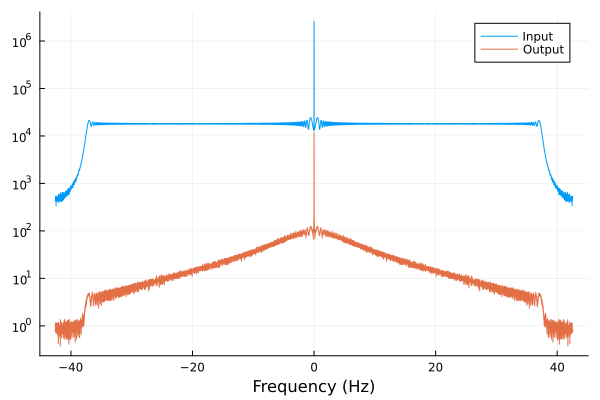

In [31]:
fft(u)

U = fftshift(fft(u))
freqs = fftshift(fftfreq(length(t), (1/dt)))

Y = fftshift(fft(y))
freqs = fftshift(fftfreq(length(t), (1/dt)))

plot(freqs, abs.(U), xlabel="Frequency (Hz)", yscale=:log10, label="Input")#, xscale=:log10, xlim=(1e-3, 1e3))
plot!(freqs, abs.(Y), xlabel="Frequency (Hz)", yscale=:log10, label="Output")#, xscale=:log10, xlim=(1e-3, 1e3))

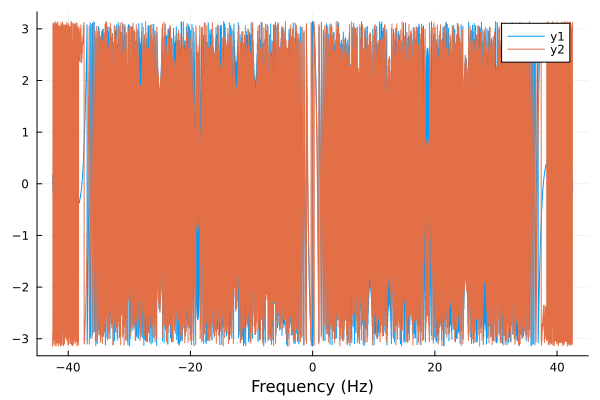

In [25]:
plot(freqs, angle.(U), xlabel="Frequency (Hz)")#, xscale=:log10, xlim=(1e-3, 1e3))
plot!(freqs, angle.(Y), xlabel="Frequency (Hz)")#, xscale=:log10, xlim=(1e-3, 1e3))

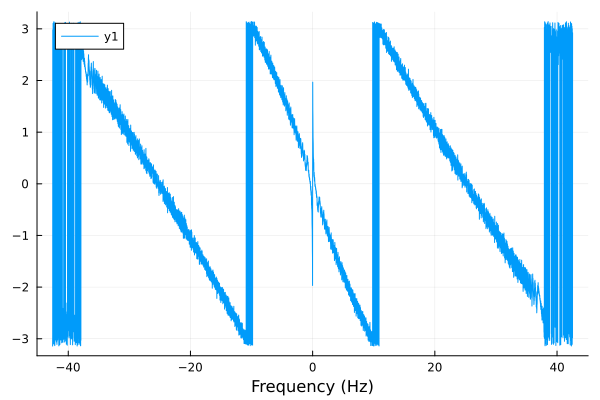

In [32]:
plot(freqs, angle.(Y./U), xlabel="Frequency (Hz)")#, xscale=:log10, xlim=(1e-3, 1e3))

In [27]:
n_freqs = length(freqs)
Y = Y[(n_freqs ÷ 2 + 5):(round(Int, n_freqs * 0.95))]
U = U[(n_freqs ÷ 2 + 5):(round(Int, n_freqs * 0.95))]
freqs = freqs[(n_freqs ÷ 2 + 5):(round(Int, n_freqs * 0.95))]

0.05319976208540966:0.013299940521352416:38.29052876097361

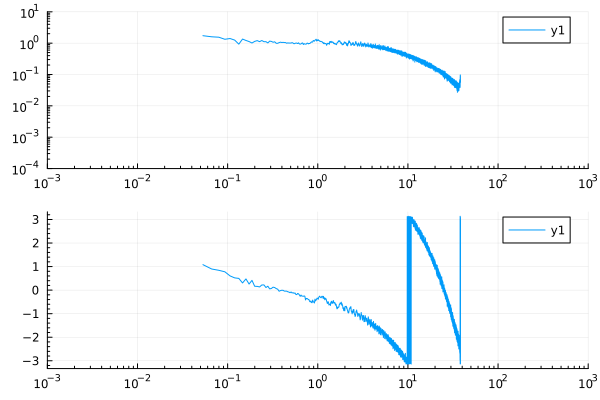

In [28]:
T = Y ./ U

p1 = plot(freqs, abs.(T) ./ K, xscale=:log10, yscale=:log10, xlim=(1e-3, 1e3), ylim=(1e-4, 1e1), minorticks=true)
p2 = plot(freqs, angle.(T), xscale=:log10, xlim=(1e-3, 1e3), minorticks=true)
plot(p1, p2, layout=(2,1))

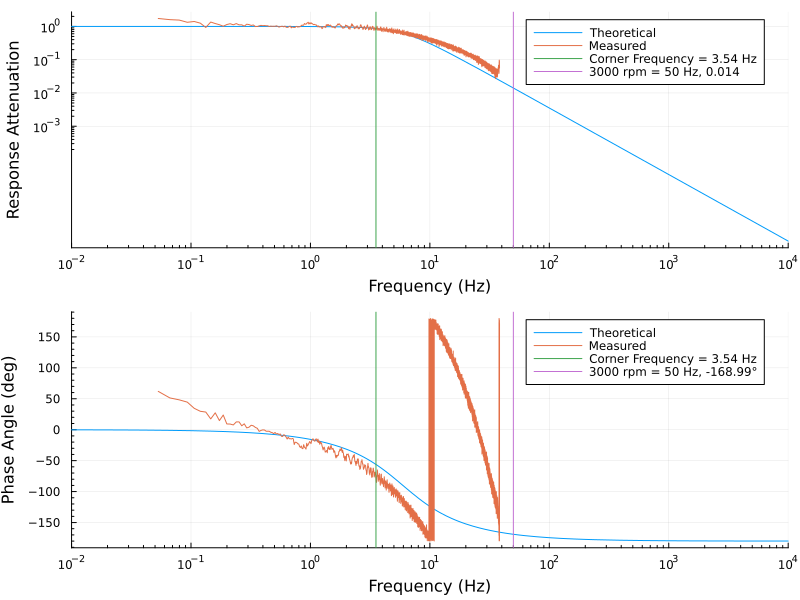

In [30]:

p1 = plot(f -> abs(G(2π * f)), xlim = (10e-3, 10e3), xscale = :log10, yscale = :log10, label = "Theoretical",
    xlabel = "Frequency (Hz)", ylabel = "Response Attenuation", minorticks = true, yticks = 10.0 .^ (-3:0))
plot!(p1, freqs, abs.(T) ./ K, label = "Measured")
vline!(p1, [1 / (2π * τ)], label = "Corner Frequency = $(round(1 / (2π * τ), digits=2)) Hz")
vline!(p1, [50.0], label = "3000 rpm = 50 Hz, $(round(abs(G(2π * 50)), digits=3))")

p2 = plot(f -> angle(G(2π * f)) * 180.0 / π, xlim = (10e-3, 10e3), xscale = :log10, label = "Theoretical",
    xlabel = "Frequency (Hz)", ylabel = "Phase Angle (deg)", minorticks = true)#, yticks=10.0 .^ (-3:0))
plot!(p2, freqs, (angle.(T)) * 180.0 / π, label = "Measured")
vline!(p2, [1 / (2π * τ)], label = "Corner Frequency = $(round(1 / (2π * τ), digits=2)) Hz")
vline!(p2, [50.0], label = "3000 rpm = 50 Hz, $(round(angle(G(2π * 50)) * 180.0 / π, digits=2))°")

plot(p1, p2, layout = (2, 1), size = (800, 600))
